In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from catalog import EarthquakeCatalog, Catalog

from sklearn.neighbors import BallTree

import torch
import pytorch_lightning as pl
import eq

(<GeoAxesSubplot: xlabel='Longitude', ylabel='Latitude'>,
 <AxesSubplot: xlabel='mag'>,
 <AxesSubplot: xlabel='Time', ylabel='mag'>)

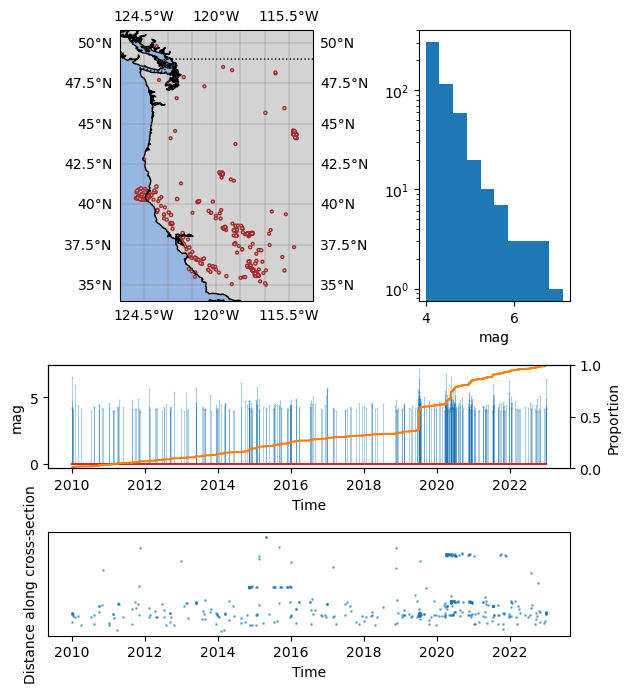

In [17]:
# Read in the data
mag_completeness = 4.0

earthquakes = EarthquakeCatalog(
    filename="data/earthquakes.csv",
    kwargs={
    "starttime": "2010-01-01",
    "endtime": "2023-01-01",
    "latitude_range": [35, 50],
    "longitude_range": [-125, -115],
    "minimum_magnitude":mag_completeness,
    }
)

earthquakes.plot_summary()

In [4]:
earthquakes.catalog.head()

,EVENT_ID,time,lat,lon,dep,mag
525,2842774,2010-01-04 14:24:51.730000128,40.2743,-123.8909,12900.0,4.3
524,2842899,2010-01-07 18:09:34.910000128,37.3802,-121.9062,10000.0,4.2
523,2842975,2010-01-10 00:27:41.850000128,40.6654,-124.4669,20600.0,6.5
522,2842987,2010-01-10 02:21:40.119999744,40.6254,-124.6176,19400.0,4.7
521,2842991,2010-01-10 03:07:02.589999616,40.6334,-124.5807,23500.0,4.1


## Declustering seismicity

In this notebook I provide an overview of declustering of seismicity. I discuss the different methods and provide a simple example of how to use them in Python along with the limitations of the various approaches.

### Introduction

Earthquakes are well known to be clustered in space and time. It is common to introduce to use the following terms which I define here: 

* **Spatial clustering** is the tendency for earthquakes to occur in clusters in space.
* **Mainshock** is the largest earthquake in a cluster.
* **Foreshock** is an earthquake that occurs before a mainshock. 
* **Aftershock** is an earthquake that occurs after the mainshock. 
* **Background seismicity** is the seismicity that is not classified as an aftershock.

A few notes here on the definitions of foreshocks, mainshocks and aftershocks. These qualifications are attributed after the fact. At the current moment, there is no robust attribute that exists to know whether and earthquake is a mainshock, or whether a larger earthquake is still to come, in which case the qualification changes and the earthquake is 'demoted' from a mainshock to a foreshock. This has lead to the devellopment other statistical models of seismicity in which all earthquakes have their own aftershocks (which may or may not be bigger).

### Declustering

It is clear however that earthquakes are clustered in time. This observation would suggests that earthquakes are the result of two different processes: one steady process that produces background seismicity, and a second process that produces clusters of earthquakes. The latter process is the one that we are interested in. The first process is the one that we want to remove from our analysis. This is the purpose of declustering. Of course the exact approach to declustering depends on the type of analysis that you are performing and the assumption of your statistical model of seismicity.

### Methods

#### Gardner-Knopoff declustering

The Gardner-Knopoff declustering method is perhaps the most straightfoward approach. Its main advantage is its simplicity; the main drawback is that it can be rather heavy handed. The method is as follows:

1. Sort the earthquakes magnitude in descending order.
2. Classify the the largest earthquake in the catalog as a mainshocks.
3. Find all earthquakes that occur within a time window of $t_{\rm window}$ and a distance window of $d_{\rm window}$ of the mainshock.
4. Classify all earthquakes within the time and distance window as aftershocks, record their abundance. 
5. Remove the mainshock and aftershocks from the catalog.
6. Repeat steps 2-5 until the catalog is empty.

The appripriate selection of the time and space window can be subjective. Alternatively, one approach might be to use a fixed time window and a distance window that is a function of the magnitude of the mainshock. For example, the distance window could be $d_{\rm window} = 10^{0.5M}$ km. Furthermore, it might be useful to select a window size that is sufficiently large that it will capture all of the aftershocks, but not so large that it will capture too many background earthquakes. One way to do this is to run the same analysis on a shuffled catalog. The window size that, for the real data, captures significantly more aftershocks the same analisys with a shuffled catalog is likely to be a good choice.

In [ ]:


def window_declustering(catalog, window_length, window_size_km):
    """ 
    1. Sort the earthquakes magnitude in descending order.
    2. Classify the the largest earthquake in the catalog as a mainshocks.
    3. Find all earthquakes that occur within a time window of $t_{\rm window}$ and a distance window of $d_{\rm window}$ of the mainshock.
    4. Classify all earthquakes within the time and distance window as aftershocks, record their abundance. 
    5. Remove the mainshock and aftershocks from the catalog.
    6. Repeat steps 2-5 until the catalog is empty.

    input:
        catalog: pandas.DataFrame
            catalog of earthquakes with columns "time", "lat", "lon", "dep", "mag"
        window_length: float
            length of the time window in days
        window_size_km: float
            size of the distance window in km

    output:
        mainshocks: pandas.DataFrame
            catalog of mainshocks with columns "time", "lat", "lon", "dep", "mag","number_of_aftershocks"
        aftershocks: pandas.DataFrame
            catalog of aftershocks with columns "time", "lat", "lon", "dep", "mag"
    """

    # Sort the earthquakes magnitude in descending order.
    catalog = catalog.sort_values(by="mag", ascending=False)

    # Classify the the largest earthquake in the catalog as a mainshocks.
    mainshocks = catalog.iloc[0]
    catalog = catalog.iloc[1:]

    # Find all earthquakes that occur within a time window of $t_{\rm window}$ and a distance window of $d_{\rm window}$ of the mainshock.
    # Classify all earthquakes within the time and distance window as aftershocks, record their abundance.
    # Remove the mainshock and aftershocks from the catalog.
    while len(catalog) > 0:
        # Find all earthquakes that occur within a time window of $t_{\rm window}$ and a distance window of $d_{\rm window}$ of the mainshock.
        mainshock = mainshocks.iloc[-1]
        time_window = catalog["time"] > mainshock["time"]
        time_window = time_window & (catalog["time"] < mainshock["time"] + window_length)
        distance_window = eq.distance(
            catalog["lat"], catalog["lon"], mainshock["lat"], mainshock["lon"]
        )
        distance_window = distance_window < window_size_km

        # Classify all earthquakes within the time and distance window as aftershocks, record their abundance.
        aftershocks = catalog[time_window & distance_window]
        mainshocks.loc[mainshock.name, "number_of_aftershocks"] = len(aftershocks)

        # Remove the mainshock and aftershocks from the catalog.
        catalog = catalog[~time_window | ~distance_window]

        # Add the mainshock and aftershocks to the mainshocks and aftershocks catalog.
        mainshocks = mainshocks.append(aftershocks)

    return mainshocks, aftershocks

#### Zaliapin nearest neighbor declustering

While Gardner-Knopoff declustering is easy to implement, it might fail to capture all of the aftershocks. In partcular it is tempting to say that earthquakes that occur almost immediately after the mainshock are likely to be aftershocks (even if they are quite far); similarly earthquakes that persist for a very long time, but are very near the mainshock may also be aftershocks. 

The Zaliapin nearest neighbor declustering method is a slightly sophisticated approach. The method goest as follows:

1. Sort the earthquakes by time.
2. For every earthquake, find caluclate the neighbor distance:
   $$ \eta_{ij} = \tau_{ij}r_{ij}^D  e^{M_i} $$
   where $\tau_{ij}$ is the time difference between the $i$th and $j$th earthquake, $r_{ij}$ is the distance between the $i$th and $j$th earthquake, $D$ is the distance exponent, and $M_i$ is the magnitude of the $i$th earthquake.
3. Create a connected graph of earthquakes to their nearest neighbors. The nearest neighbor is the earthquake with the smallest $\eta_{ij}$.
4. Cut all edges with $\eta_{ij} > \eta_{\rm cut}$.
5. For each connected cluster, 
   - find the earthquake with the largest magnitude. This is the mainshock.
   - find the earthquakes that follow the mainshock. These are the aftershocks.
   - find the earthquakes that precede the mainshock. These are the foreshocks.

Here the declustered catalog is the set of all mainshocks.

A slightly more sophisticated approach is to use the Zaliapin method followed by a thinning procedure to randmly remove certain events according to their probability of being an aftershock. See the following steps (copy pasted from Zaliapin & Ben-Zion, 2020)


1. Identify the most clustered events. This step coincides with identification of clustered events used in
the nearest‐neighbor cluster analysis of seismicity (see Zaliapin & Ben‐Zion, 2013a, and other references in
section 3); it involves a single parameter η0. The proposed declustering methodology goes beyond this crude
assessment (see Steps 2–4), and hence, the final background intensity, estimated in Step 4, may not coincide
with the estimation of Step 1.
1. Coarsely estimate the relative location‐specific background intensity at the location of each event i.
This step uses randomized‐reshuffled catalogs that exclude the most clustered events found in Step 1.
1. Calculate the normalized nearest‐neighbor proximity αi for each event, by scaling the original
nearest‐neighbor proximity ηi according to the estimated background intensities of Step 2. Ideally, the normalized proximity has the same distribution at all locations.
1. Apply thinning (random removal) to the events of the original catalog with a thinning probability
that depends on the normalized proximity αi. The remaining events comprise the declustered catalog.
This step involves a single threshold parameter α0.


For more information on the Zaliapin method see the following papers:

Zaliapin, I., and Ben-Zion, Y., 2013, Earthquake clusters in southern California I: Identification and stability: Journal of Geophysical Research: Solid Earth, v. 118, no. 6, p. 2847–2864, doi: 10.1002/jgrb.50179.

Goebel, T.H.W., Rosson, Z., Brodsky, E.E., and Walter, J.I., 2019, Aftershock deficiency of induced earthquake sequences during rapid mitigation efforts in Oklahoma: Earth and Planetary Science Letters, v. 522, p. 135–143, doi: 10.1016/j.epsl.2019.06.036.

Zaliapin, I., & Ben‐Zion, Y. (2020). Earthquake declustering using the nearest‐neighbor approach in space‐ time‐magnitude domain. Journal of Geophysical Research: Solid Earth, 125, e2018JB017120. https://doi.org/10.1029/2018JB017120


#### ETAS stochastic declustering
 
The ETAS stochastic declustering method is a more sophisticated approach. It relies on the Epidemic Type Aftershocks Sequence Model (ETAS) to model the temporal evolution of seismicity. The model represent the intensity of aftershocks as the sum of a background seismicity rate and the aftershock sequence of preceeding earthquake:

$$ \lambda = \mu + \sum(\phi(t-t_i)) $$

where $\mu$ is the background seismicity rate, $\phi(t)$ is the aftershock sequence, and $t_i$ is the time of an earthquake.

The an earthquake is said to be part of the background process with a probability: $P_{\rm bg} = \frac{\mu}{\lambda}$. A thinning procedure is then used to randomly remove earthquakes with a probability of $1/P_{\rm bg}$.

For this demo, I will use the pytorch ETAS implementation from the Dascher-Cousineau et al. (in review).

In [62]:
t_start = 0
t_end = earthquakes.duration/np.timedelta64(1, 'D')

inter_times = np.diff(
    ((earthquakes.catalog.time - earthquakes.start_time)/np.timedelta64(1, 'D')).values,
    prepend=t_start,
    append=t_end
)

seq = eq.data.Sequence(
    inter_times = torch.as_tensor(inter_times, dtype=torch.float32),
    t_start=t_start,
    t_nll_start=t_end/5, # 20% of the data is used to burn in the model but does not contribute to the loss
    t_end=t_end,
    mag=torch.as_tensor(earthquakes.catalog.mag.values, dtype=torch.float32),
)
dataset = eq.data.InMemoryDataset(sequences=[seq])
dl = dataset.get_dataloader()

model = eq.models.ETAS(
    mag_completeness=mag_completeness,
    base_rate_init=len(earthquakes)/t_end,
)
trainer = pl.Trainer(max_epochs=500, devices=1, accelerator='mps')
trainer.fit(model, dl)

/Users/kdascher/miniforge3/envs/torchETAS/lib/python3.10/site-packages/eq-0.0.1-py3.10.egg/eq/data/sequence.py:153: UserWarning: Found 1 zero inter-event times in the sequence. This violates fundamental assumptions of TPP models and may lead to incorrect log-likelihood values.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/kdascher/miniforge3/envs/torchETAS/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
5         Trainable params
0         Non-trainable params
5         Total params
0.000     Total estimated model params size (MB)
/Users/kdascher/miniforge3/envs/torchETAS/lib/python3.10/site-packages/pytorch_lightnin

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


In [63]:
mu, k, c, p, alpha = [getattr(model,param).item() for param in ["mu", "k", "c", "p", "alpha"]]
print(f"mu={mu:.2f}, k={k:.2f}, c={c:.3f}, p={p:.2f}, alpha={alpha:.1f}")

mu=0.04, k=0.01, c=0.002, p=1.06, alpha=0.9


In [66]:
mu, k, c, p, alpha = [getattr(model,param).item() for param in ["mu", "k", "c", "p", "alpha"]]

etas_rate = lambda t, ti, mi: mu + np.sum(k*10**(alpha*(mi-mag_completeness))/(t-ti+c)**p)
rate = np.array(
    [
        etas_rate(
            t, 
            seq.arrival_times[seq.arrival_times<t].detach().numpy(),
            seq.mag[seq.arrival_times<t].detach().numpy()
        ) 
        for t in seq.arrival_times.detach().numpy()
    ]
)
background_probability = model.mu.item()/rate

<AxesSubplot: xlabel='Time', ylabel='mag'>

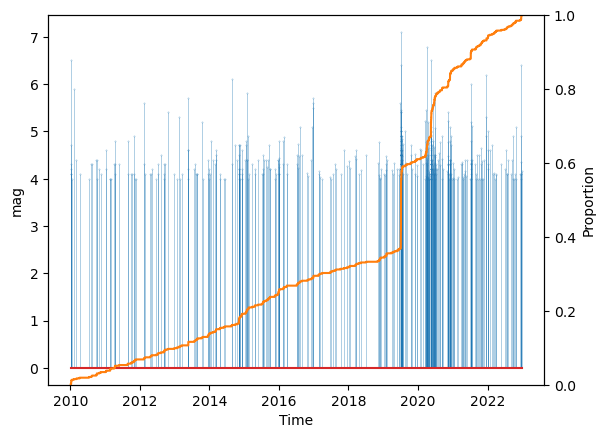

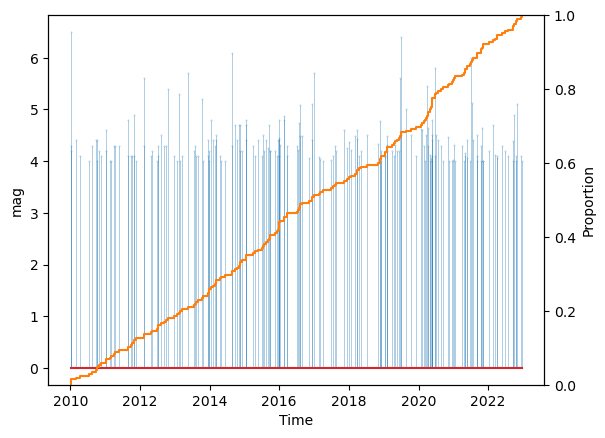

In [67]:
thinned_bool = [True if np.random.rand() < p else False for p in background_probability]
thinned_earthquakes = Catalog(earthquakes[thinned_bool])

earthquakes.plot_time_series()
thinned_earthquakes.plot_time_series()